In [200]:
import numpy as np
import matplotlib.pyplot as plt

In [201]:
from abc import ABC, abstractmethod
from typing import Callable


class Stage(ABC):
    def __init__(
        self, name: str, inventory: float, in_coming_level: float, lead_time: int
    ) -> None:
        self.name = name
        self.inventory = inventory
        self.total_orders = 0
        self.in_coming = [in_coming_level for _ in range(max(lead_time, 1))]

    # 1. Check delivery
    def check_delivery(self):
        self.inventory += self.in_coming.pop(0)

    # 2. Check orders
    def check_order(self, order: float):
        self.total_orders += order

    # 3. Deliver order -> go to transit in next stage
    def deliver_order(self) -> float:
        out = min(self.total_orders, self.inventory)
        self.total_orders -= out
        self.inventory -= out
        return out

    # 4. Make order decision
    @abstractmethod
    def make_order_decision(self) -> float: ...

    # 5. Add in transit items
    def add_in_transit(self, order: float):
        self.in_coming.append(order)

    def go_forward(self, order: float) -> tuple[float, float]:
        self.check_delivery()
        self.check_order(order)
        delivery = self.deliver_order()
        order = self.make_order_decision()
        return delivery, order

    def __repr__(self) -> str:
        return f"Stage(name={self.name:<20}, inventory={self.inventory:<15.1f}, total_orders={self.total_orders:<3.1f}, in_coming={self.in_coming})"


class BeerGame:
    def __init__(
        self,
        stage_class: type[Stage],
        weeks: int = 52,
        initial_stock: float = 20,
        demand_function: Callable[[], float] = lambda: np.random.normal(20, 4),
        lead_time: int = 4,
        **kwargs,
    ):
        self.weeks = weeks
        self.initial_stock = initial_stock
        self.demand_function = demand_function
        self.infinite_supplier = stage_class("Infinite Supplier", 1e10, 0, 0, **kwargs)
        self.manufacturer = stage_class(
            "Manufacturer", initial_stock, 20, lead_time, **kwargs
        )
        self.retailer = stage_class("Retailer", initial_stock, 20, lead_time, **kwargs)
        self.lead_time = lead_time

    def go_forward(self):
        demand = self.demand_function()

        # Step 1
        self.infinite_supplier.check_delivery()
        self.manufacturer.check_delivery()
        self.retailer.check_delivery()

        # Step 2
        self.retailer.check_order(demand)
        self.retailer.deliver_order()
        retailer_order = self.retailer.make_order_decision()

        self.manufacturer.check_order(retailer_order)
        man_produced = self.manufacturer.deliver_order()
        manufacturer_order = self.manufacturer.make_order_decision()
        self.retailer.add_in_transit(man_produced)

        self.infinite_supplier.check_order(manufacturer_order)
        inf_produced = self.infinite_supplier.deliver_order()
        self.manufacturer.add_in_transit(inf_produced)
        self.infinite_supplier.add_in_transit(
            self.infinite_supplier.make_order_decision()
        )

        return demand, retailer_order, manufacturer_order

    def simulate(self):
        simulation = {}
        for week in range(self.weeks):
            demand, retailer, manufacturer = self.go_forward()
            simulation[week] = {
                "demand": demand,
                "retailer_order": retailer,
                "manufacturer_order": manufacturer,
            }
            simulation[week]["infinite_supplier_inventory"] = (
                self.infinite_supplier.inventory
            )
            simulation[week]["infinitely_supplier_orders"] = (
                self.infinite_supplier.total_orders
            )
            simulation[week]["manufacturer_inventory"] = self.manufacturer.inventory
            simulation[week]["manufacturer_orders"] = self.manufacturer.total_orders
            simulation[week]["retailer_inventory"] = self.retailer.inventory
            simulation[week]["retailer_orders"] = self.retailer.total_orders

        return simulation

    @staticmethod
    def bullwhip_effect(sim):
        days = list(sim.keys())
        retailer_inventory = [sim[day]["retailer_inventory"] for day in days]
        manufacturer_inventory = [sim[day]["manufacturer_inventory"] for day in days]
        demand_inventory = [sim[day]["demand"] for day in days]
        return np.var(retailer_inventory) / np.var(demand_inventory), np.var(
            manufacturer_inventory
        ) / np.var(demand_inventory)

    def visualise_simulation(self, simulation):
        days = list(simulation.keys())
        demand = [simulation[day]["demand"] for day in days]
        retailer_order = [simulation[day]["retailer_order"] for day in days]
        manufacturer_order = [simulation[day]["manufacturer_order"] for day in days]
        # infinitely_supplier_orders = [simulation[day]["infinitely_supplier_orders"] for day in days]
        plt.plot(days, demand, label="Demand")
        plt.plot(days, retailer_order, label="Retailer Order")
        plt.plot(days, manufacturer_order, label="Manufacturer Order")
        plt.legend()

    def __repr__(self):
        return f"BeerGame(weeks={self.weeks}, initial_stock={self.initial_stock}, demand_function={self.demand_function}, lead_time={self.lead_time})\n{self.infinite_supplier}\n{self.manufacturer}\n{self.retailer}"

In [202]:
class RandomStage(Stage):
    def make_order_decision(self) -> float:
        return np.random.normal(self.total_orders, 1)

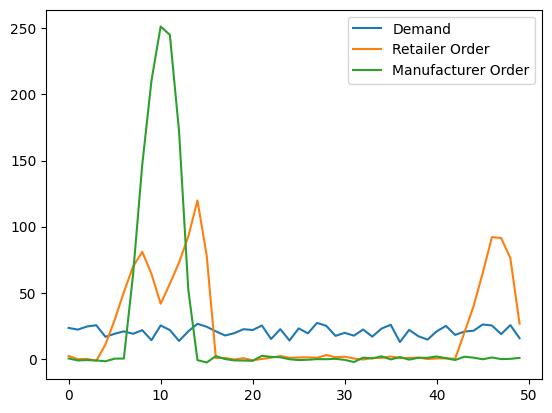

In [203]:
# Make sure it works, we react to the demand observe by ordering by the number of orders that we have recieved and not yet delivered
# We are looking at wheter or not we are observing the bullwhip effect (especially for the manufacturer)
rand_bg = BeerGame(RandomStage, weeks=50)
rand_sim = rand_bg.simulate()
rand_bg.visualise_simulation(rand_sim)

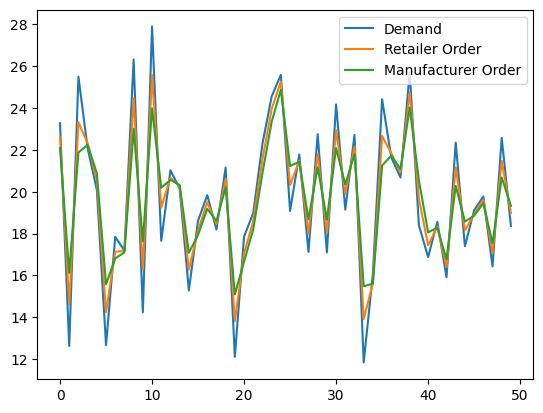

In [204]:
class ExponentialSmoothingStage(Stage):
    def __init__(
        self,
        name: str,
        inventory: float,
        in_coming_level: float,
        lead_time: int,
        alpha: float = 0.8,
    ) -> None:
        super().__init__(name, inventory, in_coming_level, lead_time)
        self.alpha = alpha
        self.forecast = inventory

    def check_order(self, order: float):
        self.forecast = self.alpha * order + (1 - self.alpha) * self.forecast
        return super().check_order(order)

    def make_order_decision(self) -> float:
        return self.forecast


exp_bg = BeerGame(ExponentialSmoothingStage, weeks=50)
exp_sim = exp_bg.simulate()
exp_bg.visualise_simulation(exp_sim)

Since the bullwhip effect causes a big deviation from the mean we will use the variance of the demand and the order levels. The ratio of $\tilde{b}=\frac{\text{Var}(\text{manufacturer})}{\text{Var}(\text{demand})}$ will show wheter or not we have a bullwhip effect if the ratio is $\tilde{b}\gg 1$. Below we have emperical proof that the metric works, by seeing that in the random stage strategy we have a much higher ratio compared to the exponential smoothing.

In [205]:
days = list(exp_sim.keys())
retailer_inventory = [exp_sim[day]["retailer_inventory"] for day in days]
manufacturer_inventory = [exp_sim[day]["manufacturer_inventory"] for day in days]
demand_inventory = [exp_sim[day]["demand"] for day in days]
(
    np.var(retailer_inventory) / np.var(demand_inventory),
    np.var(manufacturer_inventory) / np.var(demand_inventory),
)

(np.float64(2.590727678265173), np.float64(2.2289727961865338))

In [206]:
retailer_inventory = [rand_sim[day]["manufacturer_inventory"] for day in days]
manufacturer_inventory = [rand_sim[day]["retailer_inventory"] for day in days]
demand_inventory = [rand_sim[day]["demand"] for day in days]
(
    np.var(retailer_inventory) / np.var(demand_inventory),
    np.var(manufacturer_inventory) / np.var(demand_inventory),
)

(np.float64(2622.902908436733), np.float64(1490.6431566122817))

In [207]:
alpha_values = np.linspace(0, 1, 101)
bullwhip_effect = {
    (alpha, stage): []
    for alpha in alpha_values
    for stage in ["retailer", "manufacturer"]
}
for alpha in alpha_values:
    for _ in range(100):
        exp_bg = BeerGame(ExponentialSmoothingStage, weeks=50, alpha=alpha)
        sim = exp_bg.simulate()
        b_tilde = exp_bg.bullwhip_effect(sim)
        bullwhip_effect[alpha, "retailer"].append(b_tilde[0])
        bullwhip_effect[alpha, "manufacturer"].append(b_tilde[1])

Text(0.5, 1.0, 'Bullwhip effect ($\\tilde{b}$) for different alpha values')

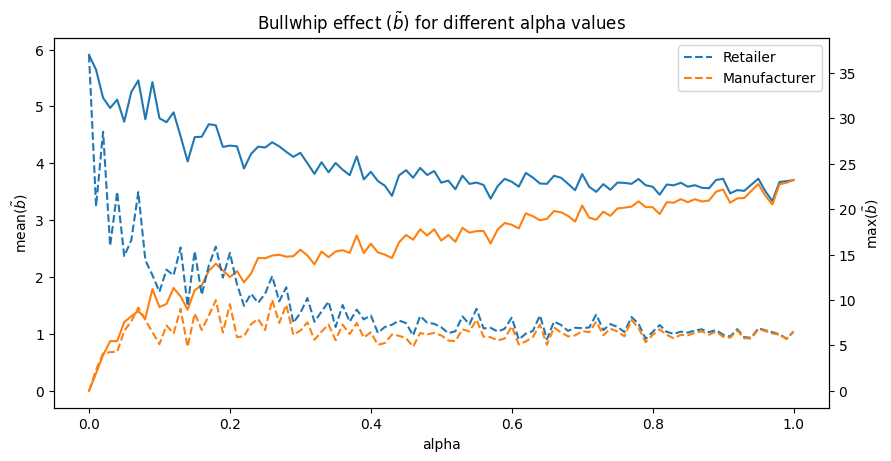

In [ ]:
# Plot mean values of alpha
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
ax1.set_xlabel("alpha")

retailer_mean = [np.mean(bullwhip_effect[alpha, "retailer"]) for alpha in alpha_values]
manufacturer_mean = [
    np.mean(bullwhip_effect[alpha, "manufacturer"]) for alpha in alpha_values
]

ax1.plot(alpha_values, retailer_mean, label="Retailer")
ax1.plot(alpha_values, manufacturer_mean, label="Manufacturer")
ax1.set_ylabel(r"mean($\tilde{b}$)")

# Add second y-axis with max values
ax2 = ax1.twinx()

retailer_max = [np.max(bullwhip_effect[alpha, "retailer"]) for alpha in alpha_values]
manufacturer_max = [
    np.max(bullwhip_effect[alpha, "manufacturer"]) for alpha in alpha_values
]

ax2.plot(alpha_values, retailer_max, label="Retailer", linestyle="--")
ax2.plot(alpha_values, manufacturer_max, label="Manufacturer", linestyle="--")
ax2.set_ylabel(r"max($\tilde{b}$)")

plt.legend()
plt.title(r"Bullwhip effect ($\tilde{b}$) for different alpha values")
